<a href="https://colab.research.google.com/github/ayyucedemirbas/paligemma/blob/main/fracture_paligemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import json

from typing import List
from google.colab import userdata

import os
import sys
import base64
import functools
import html
import io
import warnings
import tensorflow as tf

import jax
import jax.numpy as jnp
import numpy as np


from IPython.core.display import display, HTML
from PIL import Image
from tqdm.notebook import tqdm
import kagglehub

In [5]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"your_username","key":"your_key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
!pip install -q roboflow
!pip install -q git+https://github.com/roboflow/supervision.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 871.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.5 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
from roboflow import Roboflow
import supervision as sv

In [4]:
rf = Roboflow(api_key="your_key")
project = rf.workspace("landy-aw2jb").project("fracture-ov5p1")
version = project.version(1)
dataset = version.download("paligemma")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to fracture-1 in paligemma:: 100%|██████████| 22563/22563 [00:05<00:00, 3978.39it/s]


In [6]:
!head -n 5 {dataset.location}/dataset/_annotations.train.jsonl

{"image":"dd3a540c731c104f87cec499b3922a_jumbo-2_jpg.rf.000003ef29c065c6bcbd6ecf16601adf.jpg","prefix":"detect Fracture Detection - v1 2024-04-12 4-09pm","suffix":"<loc0765><loc0340><loc0936><loc0502> Fracture Detection - v1 2024-04-12 4-09pm"}
{"image":"hand_5th_metacarpal_fracture_jumbo_jpeg_jpg.rf.00036e35f40d2a6d419338e85dd1447f.jpg","prefix":"detect Fracture Detection - v1 2024-04-12 4-09pm","suffix":"<loc0601><loc0650><loc0656><loc0711> Fracture Detection - v1 2024-04-12 4-09pm"}
{"image":"c3cf7e661b672313183dfeb75ebf33_jumbo-2_jpg.rf.0039f16f1357473e1e6ce9f1b97b1084.jpg","prefix":"detect Fracture Detection - v1 2024-04-12 4-09pm","suffix":"<loc0552><loc0751><loc0616><loc0834> Fracture Detection - v1 2024-04-12 4-09pm"}
{"image":"57d0d7a56193e53397d9658fa28134f2-medical-imaging-types-of_jpg.rf.003d1cdd60bf1b2046797e0537dcd8a0.jpg","prefix":"detect Fracture Detection - v1 2024-04-12 4-09pm","suffix":"<loc0557><loc0364><loc0645><loc0454> Fracture Detection - v1 2024-04-12 4-09pm"}


In [7]:
!head -n 5 {dataset.location}/dataset/_annotations.valid.jsonl

{"image":"7032e0ee7c316a64fe3f593c40c55a_jumbo_jpeg_jpg.rf.00469940bbd550cdf7b237da61e098e2.jpg","prefix":"detect Fracture Detection - v1 2024-04-12 4-09pm","suffix":"<loc0753><loc0443><loc0852><loc0561> Fracture Detection - v1 2024-04-12 4-09pm"}
{"image":"image-16-_jpeg_jpg.rf.00683121af0f47093625b1adbee99392.jpg","prefix":"detect Fracture Detection - v1 2024-04-12 4-09pm","suffix":"<loc0387><loc0657><loc0569><loc0812> Fracture Detection - v1 2024-04-12 4-09pm"}
{"image":"RPphalanx_jumbo-2_jpg.rf.021864fde2f3e88aa652e00e84f2fcdc.jpg","prefix":"detect Fracture Detection - v1 2024-04-12 4-09pm","suffix":"<loc0526><loc0452><loc0776><loc0620> Fracture Detection - v1 2024-04-12 4-09pm"}
{"image":"97c89bcea24f023db7d7505b7153bf_jumbo-2_jpg.rf.0121dc68a0e991dbaa3e4fc0d878dc98.jpg","prefix":"detect Fracture Detection - v1 2024-04-12 4-09pm","suffix":"<loc0160><loc0520><loc0238><loc0588> Fracture Detection - v1 2024-04-12 4-09pm"}
{"image":"image-5-_jpeg_jpg.rf.004c7e7449ea858b4007b75aa707627

In [8]:
def read_n_lines(file_path: str, n: int) -> List[str]:
    with open(file_path, 'r') as file:
        lines = [next(file).strip() for _ in range(n)]
    return lines

In [9]:
dataset.location

'/content/fracture-1'

In [10]:
images = []
lines = read_n_lines(f"{dataset.location}/dataset/_annotations.train.jsonl", 25)
first = json.loads(lines[0])

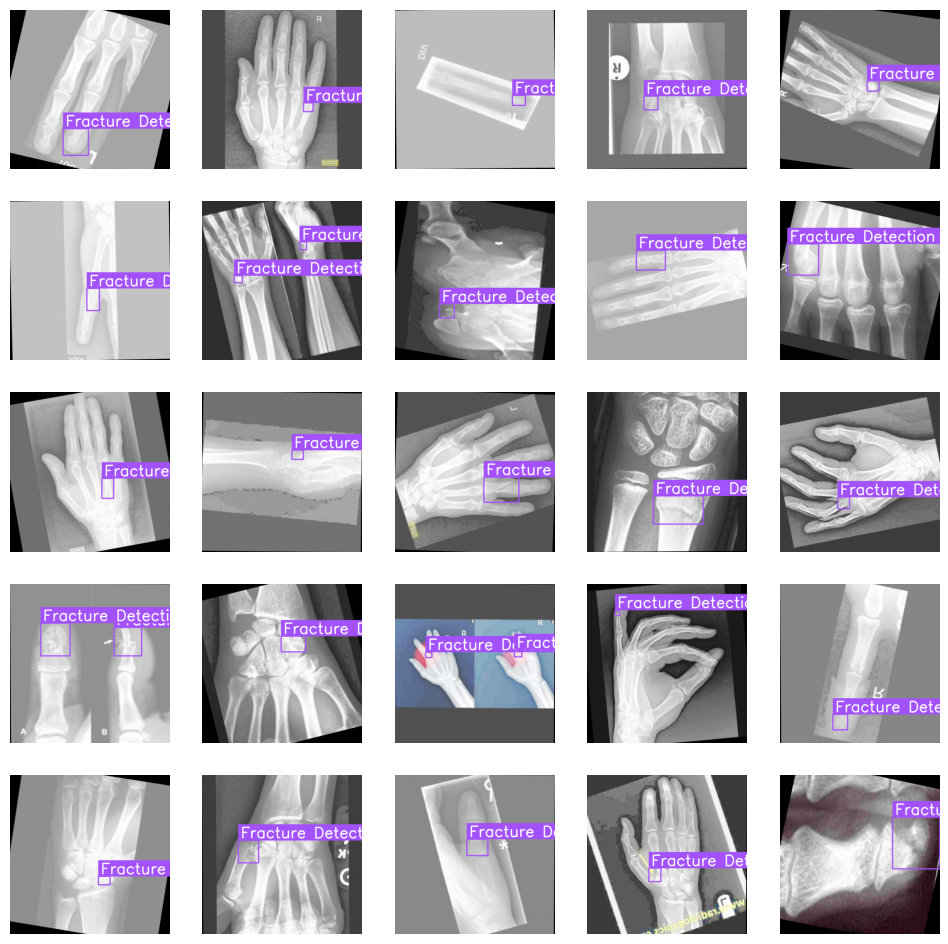

In [11]:
CLASSES = first.get('prefix').replace("detect ", "").split(" ; ")

for line in lines:
    data = json.loads(line)
    image = cv2.imread(f"{dataset.location}/dataset/{data.get('image')}")
    (h, w, _) = image.shape
    detections = sv.Detections.from_lmm(
        lmm='paligemma',
        result=data.get('suffix'),
        resolution_wh=(w, h),
        classes=CLASSES)

    image = sv.BoundingBoxAnnotator(thickness=4).annotate(image, detections)
    image = sv.LabelAnnotator(text_scale=2, text_thickness=4).annotate(image, detections)
    images.append(image)

sv.plot_images_grid(images, (5, 5))

In [12]:
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

In [13]:
!git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

In [14]:
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

In [15]:
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.2 MB/s eta 0:00:00


In [16]:
import ml_collections
import sentencepiece

In [17]:
# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.26
JAX platform: gpu
JAX devices:  1


In [18]:
MODEL_PATH = "./pt_224_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
    print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
    # Note: kaggle archive contains the same checkpoint in multiple formats.
    # Download only the float16 model.
    MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', 'paligemma-3b-pt-224.f16.npz')
    print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")

100%|██████████| 5.45G/5.45G [05:52<00:00, 16.6MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
\ [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


In [19]:
# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

In [20]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

In [21]:
def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)

In [22]:
SEQLEN = 128

train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.train.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.valid.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})


def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


Training examples



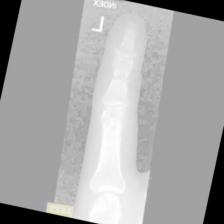
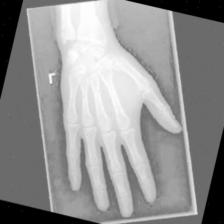
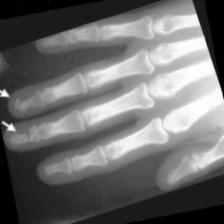
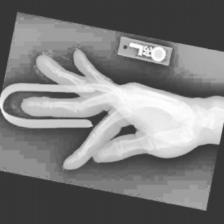

In [23]:
def split_and_keep_second_part(s):
    parts = s.split('\n', 1)
    if len(parts) > 1:
        return parts[1]
    return s

def render_inline(image, resize=(128, 128)):
    """Convert image into inline html."""
    image = Image.fromarray(image)
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
    image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
    h, w, _ = image.shape
    try:
        detections = sv.Detections.from_lmm(
            lmm='paligemma',
            result=caption,
            resolution_wh=(w, h),
            classes=CLASSES)
        image = sv.BoundingBoxAnnotator().annotate(image, detections)
        image = sv.LabelAnnotator().annotate(image, detections)
    except:
        print(caption)
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
    <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
</div>
"""

html_out = ""
for idx, example in zip(range(4), train_data_iterator()):
    caption = postprocess_tokens(example["text"])  # detokenize model input.
    caption = split_and_keep_second_part(caption)
    html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

In [24]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    labels = [postprocess_tokens(e["label"]) for e in examples]
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, label, response in zip(examples, labels, responses):
      outputs.append((example["image"], label, response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

step:  1/64   lr: 0.00083   loss: 0.9954
step:  2/64   lr: 0.00167   loss: 0.9161
step:  3/64   lr: 0.00250   loss: 0.9429
step:  4/64   lr: 0.00333   loss: 0.8590
step:  5/64   lr: 0.00417   loss: 0.9036
step:  6/64   lr: 0.00500   loss: 0.8671
step:  7/64   lr: 0.00500   loss: 0.8648
step:  8/64   lr: 0.00499   loss: 0.8501
Model predictions at step 8



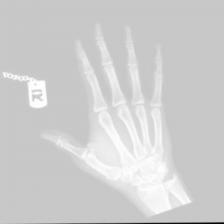
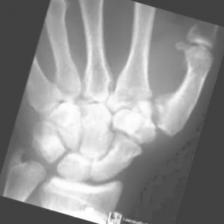
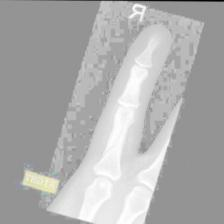
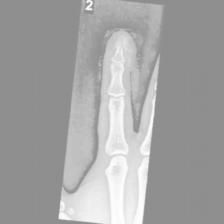

step:  9/64   lr: 0.00497   loss: 0.8220
step: 10/64   lr: 0.00494   loss: 0.8676
step: 11/64   lr: 0.00491   loss: 0.8231
step: 12/64   lr: 0.00487   loss: 0.8446
step: 13/64   lr: 0.00483   loss: 0.8415
step: 14/64   lr: 0.00478   loss: 0.8095
step: 15/64   lr: 0.00472   loss: 0.8170
step: 16/64   lr: 0.00465   loss: 0.8094
Model predictions at step 16



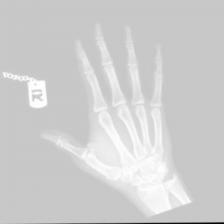
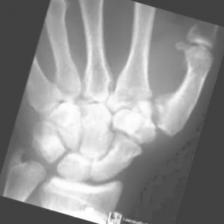
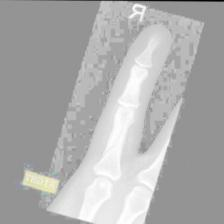
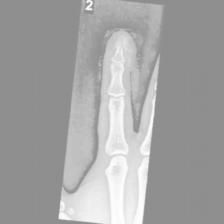

step: 17/64   lr: 0.00458   loss: 0.8087
step: 18/64   lr: 0.00451   loss: 0.8085
step: 19/64   lr: 0.00442   loss: 0.8853
step: 20/64   lr: 0.00434   loss: 0.9036
step: 21/64   lr: 0.00424   loss: 0.8583
step: 22/64   lr: 0.00415   loss: 0.8621
step: 23/64   lr: 0.00404   loss: 0.8574
step: 24/64   lr: 0.00394   loss: 0.8271
Model predictions at step 24



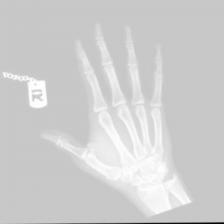
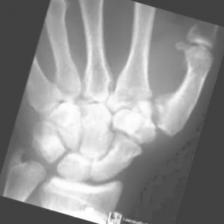
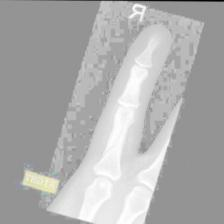
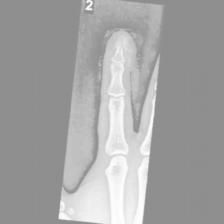

step: 25/64   lr: 0.00383   loss: 0.8049
step: 26/64   lr: 0.00371   loss: 0.8305
step: 27/64   lr: 0.00359   loss: 0.8220
step: 28/64   lr: 0.00347   loss: 0.8033
step: 29/64   lr: 0.00335   loss: 0.8293
step: 30/64   lr: 0.00322   loss: 0.8105
step: 31/64   lr: 0.00309   loss: 0.7860
step: 32/64   lr: 0.00296   loss: 0.7761
Model predictions at step 32



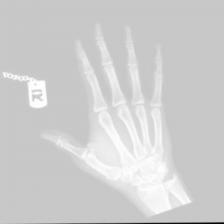
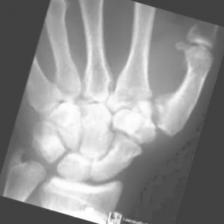
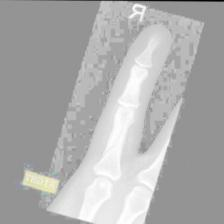
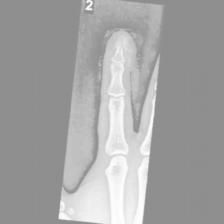

step: 33/64   lr: 0.00283   loss: 0.8365
step: 34/64   lr: 0.00270   loss: 0.8026
step: 35/64   lr: 0.00257   loss: 0.8164
step: 36/64   lr: 0.00243   loss: 0.8251
step: 37/64   lr: 0.00230   loss: 0.8438
step: 38/64   lr: 0.00217   loss: 0.8168
step: 39/64   lr: 0.00204   loss: 0.8076
step: 40/64   lr: 0.00191   loss: 0.8119
Model predictions at step 40



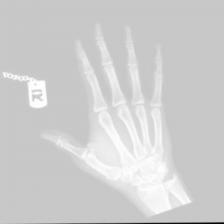
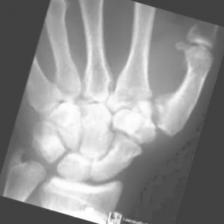
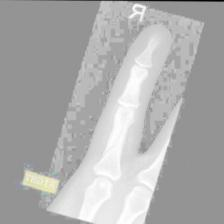
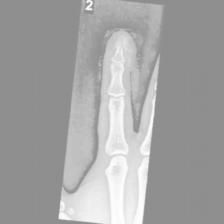

step: 41/64   lr: 0.00178   loss: 0.8083
step: 42/64   lr: 0.00165   loss: 0.8184
step: 43/64   lr: 0.00153   loss: 0.7749
step: 44/64   lr: 0.00141   loss: 0.8221
step: 45/64   lr: 0.00129   loss: 0.8302
step: 46/64   lr: 0.00117   loss: 0.8165
step: 47/64   lr: 0.00106   loss: 0.8301
step: 48/64   lr: 0.00096   loss: 0.8084
Model predictions at step 48



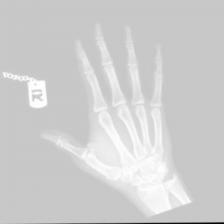
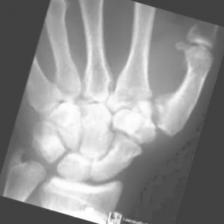
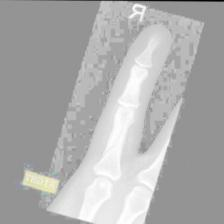
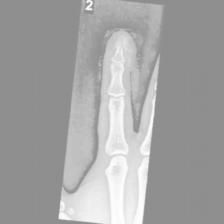

step: 49/64   lr: 0.00085   loss: 0.8357
step: 50/64   lr: 0.00076   loss: 0.8032
step: 51/64   lr: 0.00066   loss: 0.7955
step: 52/64   lr: 0.00058   loss: 0.8217
step: 53/64   lr: 0.00049   loss: 0.8730
step: 54/64   lr: 0.00042   loss: 0.8020
step: 55/64   lr: 0.00035   loss: 0.8066
step: 56/64   lr: 0.00028   loss: 0.7944
Model predictions at step 56



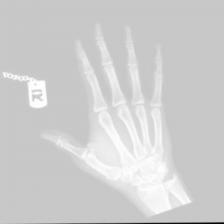
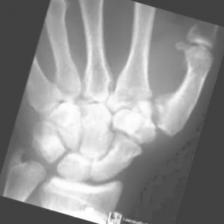
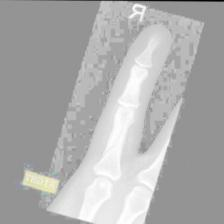
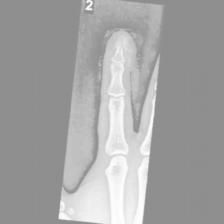

step: 57/64   lr: 0.00022   loss: 0.8295
step: 58/64   lr: 0.00017   loss: 0.8389
step: 59/64   lr: 0.00013   loss: 0.8218
step: 60/64   lr: 0.00009   loss: 0.8501
step: 61/64   lr: 0.00006   loss: 0.8162
step: 62/64   lr: 0.00003   loss: 0.8756
step: 63/64   lr: 0.00001   loss: 0.7422
step: 64/64   lr: 0.00000   loss: 0.8633
Model predictions at step 64



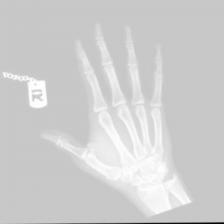
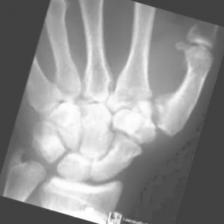
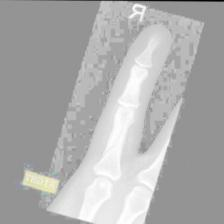
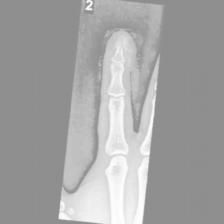

CPU times: user 11min 33s, sys: 424 ms, total: 11min 34s
Wall time: 11min 56s


In [25]:
# Run a short training loop with cosine learning rate schedule.
#
# Note: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#
%%time

BATCH_SIZE = 8
TRAIN_EXAMPLES = 512
LEARNING_RATE = 0.005

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 8

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, _, caption in make_predictions(
        validation_data_iterator(), num_examples=4, batch_size=4):
      html_out += render_example(image, caption)
    display(HTML(html_out))


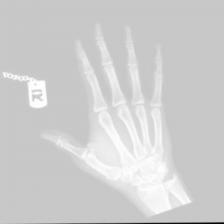
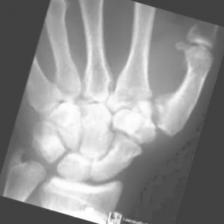
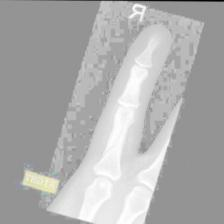
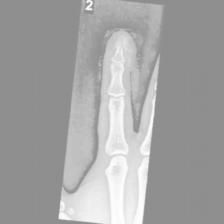
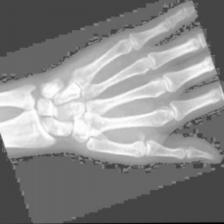
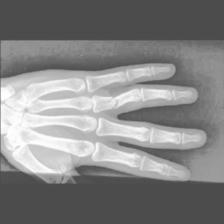
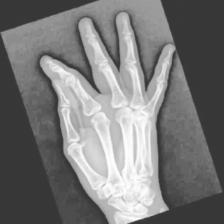
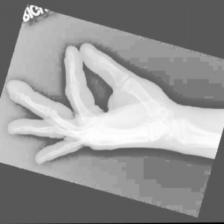
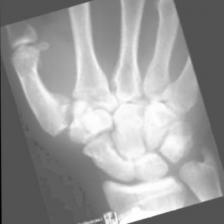
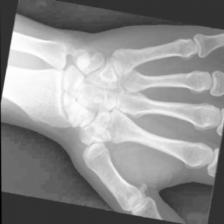
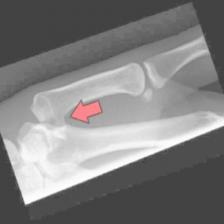
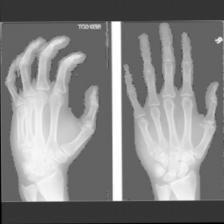
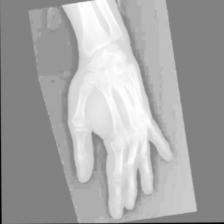
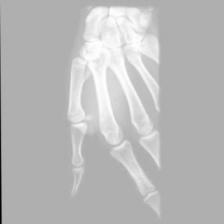
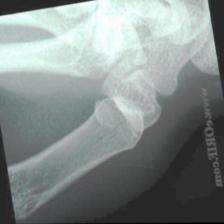
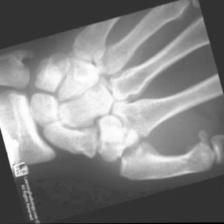

In [26]:
# @title Visualize results
html_out = ""
for image, _, caption in make_predictions(validation_data_iterator(), num_examples=16, batch_size=8):
  html_out += render_example(image, caption)
display(HTML(html_out))

In [27]:
# @title Collect predictions
targets = []
predictions = []

for image, label, prediction in make_predictions(validation_data_iterator(), num_examples=512, batch_size=8):
    h, w, _ = image.shape
    target = sv.Detections.from_lmm(
        lmm='paligemma',
        result=label,
        resolution_wh=(w, h),
        classes=CLASSES)
    targets.append(target)
    prediction = sv.Detections.from_lmm(
        lmm='paligemma',
        result=prediction,
        resolution_wh=(w, h),
        classes=CLASSES)
    prediction.confidence = np.ones(len(prediction))
    predictions.append(prediction)

In [28]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.00
map50: 0.00
map75: 0.00


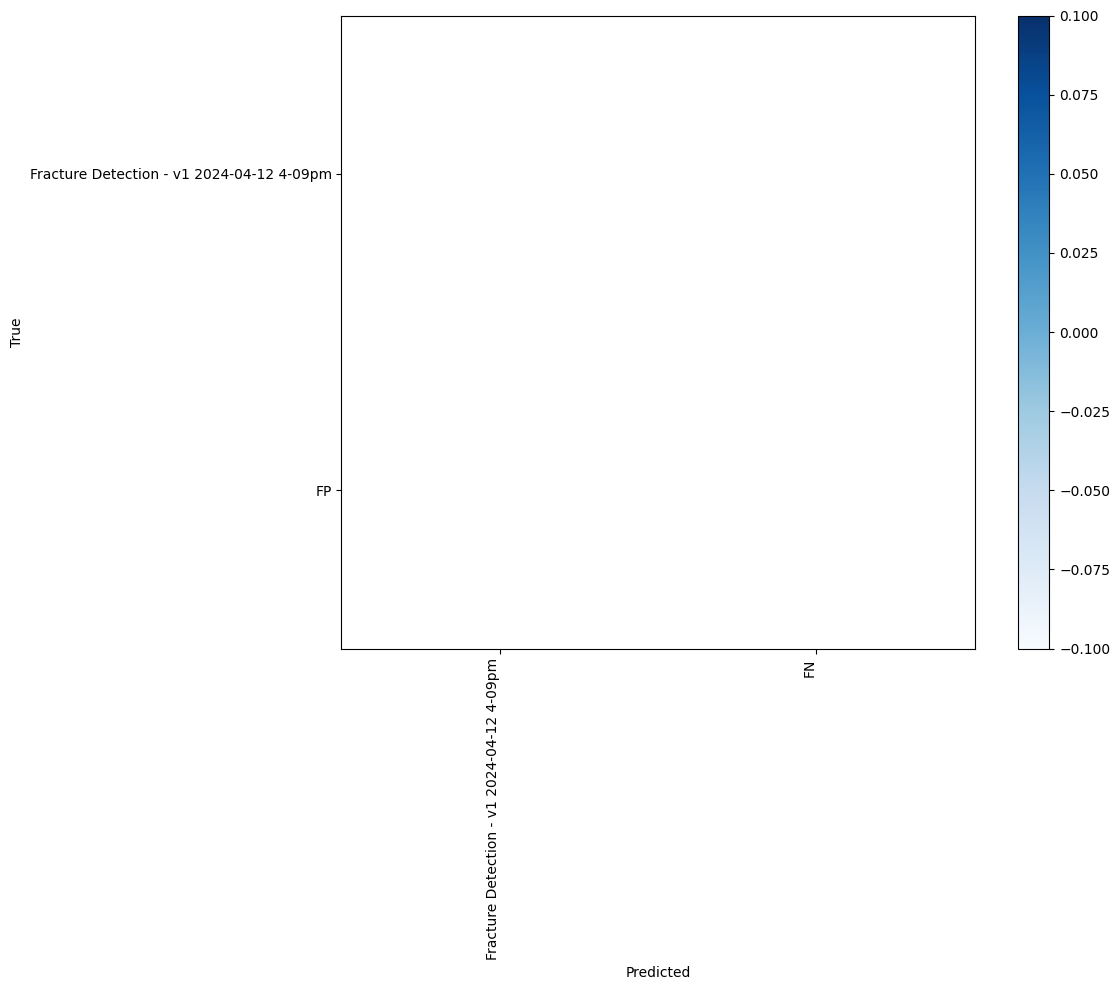

In [29]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

In [30]:
TARGET_MODEL_DIR = f"{dataset.location}/model"
TARGET_MODEL_PATH = f"{TARGET_MODEL_DIR}/paligemma-3b-pt-224.f16.npz"

os.makedirs(TARGET_MODEL_DIR, exist_ok=True)

In [31]:
flat, _ = big_vision.utils.tree_flatten_with_names(params)
with open(TARGET_MODEL_PATH, "wb") as f:
  np.savez(f, **{k: v for k, v in flat})

In [ ]:
version.deploy(model_type="paligemma-3b-pt-224", model_path=TARGET_MODEL_DIR)

In [33]:
!ls -al

total 4196
drwxr-xr-x 1 root root    4096 Jun 19 00:50 .
drwxr-xr-x 1 root root    4096 Jun 18 23:57 ..
drwxr-xr-x 4 root root    4096 Jun 19 00:02 big_vision_repo
drwxr-xr-x 4 root root    4096 Jun 14 17:38 .config
drwx------ 5 root root    4096 Jun 19 00:50 drive
drwxr-xr-x 4 root root    4096 Jun 19 00:30 fracture-1
-rw-r--r-- 1 root root 4264023 Jun 19 00:09 paligemma_tokenizer.model
drwxr-xr-x 1 root root    4096 Jun 14 17:39 sample_data


In [34]:
!cp paligemma_tokenizer.model /content/drive/MyDrive